In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import jax
import jax.numpy as jnp
from   jax import jit, vmap
import bayes3d as b3d
import genjax
from   genjax import gen, choice_map, vector_choice_map
from   genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import matplotlib.pyplot as plt
from   matplotlib.collections import LineCollection
import numpy as np
import trimesh
from functools import partial
from pathlib import Path
import os

key = jax.random.PRNGKey(0)

In [106]:
from xsight.utils import *
from xsight.meshes import Viewer
from xsight.pose import pack_pose, unpack_pose, CAM_ALONG_X, from_euler
from jax.scipy.spatial.transform import Rotation

In [55]:
n = 100
key, keys = keysplit(key,1,2)
qs = 0.1*jax.random.normal(keys[0], (n,4))
qs = qs.at[:,3].set(1.0)
xs = 0.1*jax.random.normal(keys[1], (n,3))

In [59]:
 v = Viewer(background="#ccc")

for x,r in zip(xs,Rotation.from_quat(qs).as_matrix()):
    v.add_pose(pack_pose(x, r))

v

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.6, positio…

In [60]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []

for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)

In [62]:
#| Set up the renderer and add the scene mesh
def make_render_function(meshes, w=100, h=100, fx=30, fy=30, far=20, near=0.01):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx=fx, fy=fy,
        cx=w/2 - 0.5, cy=h/2 - 0.5,
        near=near, far=far
    )
    
    b3d.setup_renderer(intrinsics)
    for mesh in meshes:
        b3d.RENDERER.add_mesh(mesh, center_mesh=True)


    def render(p:"3D Pose", inds=[0]):
        """
        Render a rendered image from a fixed scene that this is closed over.
        The image is made up off 4 channels x,y,z, and
        a "semantic layer" containing object ids.
        """
        p_ = b3d.t3d.inverse_pose(p)
        X  = b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))
        return X;

    return render

In [65]:
_far = 3.0
intrinsics = dict(w=100,h=100, fx=150, fy=150, near=0.0001, far=_far)

_render = make_render_function(meshes, **intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [70]:
inv = jnp.linalg.inv

In [187]:
def prep_im(Y, far=_far, eps=1e-6):
    im = np.where(Y[:,:,2]>= _far - eps, jnp.inf, Y[:,:,2])
    return im

#|export
def lift_pose(x, hd, z=0.0, pitch=0.0, roll=0.0):
    """Lifts a 2d pose (x,hd) to 3d"""
    return pack_pose(
        jnp.concatenate([x, jnp.array([z])]),
        from_euler(hd)
    ) 

render = jit(vmap(lambda cam, p, i: _render(inv(p)@cam, jnp.array([i])), (0,None,None))) 

62.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


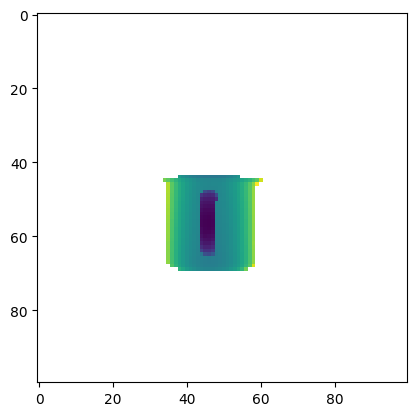

In [230]:
n = 10_000
key, keys = keysplit(key,1,2)
qs = 0.01*jax.random.normal(keys[0], (n,4))
qs = qs.at[:,3].set(1.0)
rs = Rotation.from_quat(qs).as_matrix()@CAM_ALONG_X
xs = 0.001*jax.random.normal(keys[1], (n,3)) + jnp.array([-.5,0.0,0.0])
xs = xs.at[0].set(jnp.array([-0.5,.0,.0]))
ps = vmap(pack_pose)(xs, rs)


Y = render(ps,lift_pose(jnp.zeros(2), -jnp.pi), 13)

%timeit -n 1 -r 1 render(ps,lift_pose(jnp.zeros(2), -jnp.pi), 13);

plt.imshow(prep_im(Y[0]))

(81,)


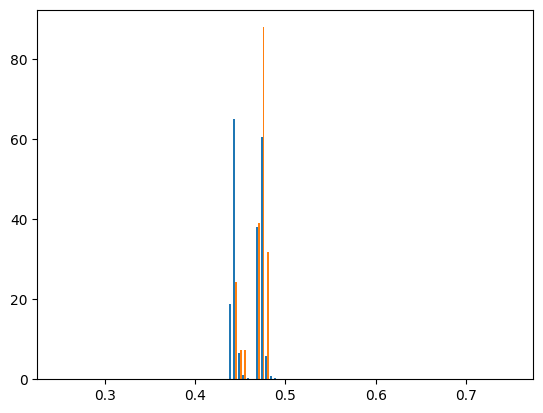

In [234]:
w = 4
ys = Y[:, intrinsics["h"]//2, intrinsics["w"]//2, 2]
ws = Y[0,intrinsics["h"]//2-w:intrinsics["h"]//2+w+1, intrinsics["w"]//2-w:intrinsics["w"]//2+w+1, 2].ravel()
# bins = jnp.linspace(0.25, 0.75, 200)
bins = jnp.linspace(0.25, 0.75, 100)
# bins = jnp.linspace(0., _far, 70)
print(ws.shape)

plt.hist([ys,ws], bins=bins,zorder=2, density=True);
# plt.scatter(Y[0,intrinsics["h"]//2-w:intrinsics["h"]//2+w+1, intrinsics["w"]//2-w:intrinsics["w"]//2+w+1, 2].ravel(), jnp.ones((2*w+1)**2))
# plt.scatter(, jnp.ones((2*w+1)**2), zorder=20,c="r",s=1)
# plt.hist(ws, bins=bins,zorder=2, color="r", density=True);